In [ ]:
from src.model import VAE
from src.trainer import SEPVAETrainer
from src.utils import interpolate_latent
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)
# mnist = torchvision.datasets.FashionMNIST("../data", train=True, download=True)

In [4]:
from src.utils import StyledMNISTGenerator, StyledMNIST

In [60]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [ ]:
np.random.seed(101)
torch.manual_seed(101)

In [7]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


In [ ]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


In [ ]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


### cosine sim + mi minimization (tc)

In [134]:
Z_DIM = 16
TEMP = 0.1
ALPHA = 1e2

vae = VAE(total_z_dim=Z_DIM).to(device)
factor_cls = nn.Sequential(
    nn.Linear(Z_DIM, Z_DIM),
    nn.ReLU(),
    nn.Linear(Z_DIM, 1),
    nn.Sigmoid(),
).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
factor_optimizer = torch.optim.Adam(factor_cls.parameters(), lr=1e-4)
trainer = SEPVAETrainer(
    vae,
    factor_cls,
    optimizers={"vae_optim": vae_optimizer, "factor_optim": factor_optimizer},
    sim_fn="cosine",
    hyperparameter={
        "temperature": TEMP,
        "beta": 1 / 8,
        "loc": 0,
        "scale": 1,
        "alpha": ALPHA,
        "lambda": 1,
    },
    verbose_period=5,
    device=device,
)

In [135]:
factor_d_losses = trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 208.26it/s]


val_recontr_loss=62.142, val_kl_c=9.508, val_kl_s=15.102, val_c_loss=0.256, val_mi_loss=0.048
gMIG: 0.172; elbo: -86.752


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 196.29it/s]


val_recontr_loss=30.846, val_kl_c=10.761, val_kl_s=16.270, val_c_loss=0.128, val_mi_loss=0.071
gMIG: 0.225; elbo: -57.877


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 208.29it/s]


val_recontr_loss=24.632, val_kl_c=11.421, val_kl_s=17.307, val_c_loss=0.110, val_mi_loss=0.123
gMIG: 0.235; elbo: -53.36


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 207.31it/s]


val_recontr_loss=21.620, val_kl_c=12.240, val_kl_s=18.166, val_c_loss=0.101, val_mi_loss=0.173
gMIG: 0.245; elbo: -52.026


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 189.71it/s]


val_recontr_loss=20.122, val_kl_c=12.898, val_kl_s=18.410, val_c_loss=0.090, val_mi_loss=0.189
gMIG: 0.26; elbo: -51.43


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 186.54it/s]


val_recontr_loss=19.655, val_kl_c=14.341, val_kl_s=18.455, val_c_loss=0.121, val_mi_loss=0.230
gMIG: 0.264; elbo: -52.451


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 197.15it/s]


val_recontr_loss=17.901, val_kl_c=13.856, val_kl_s=18.451, val_c_loss=0.096, val_mi_loss=0.193
gMIG: 0.27; elbo: -50.208


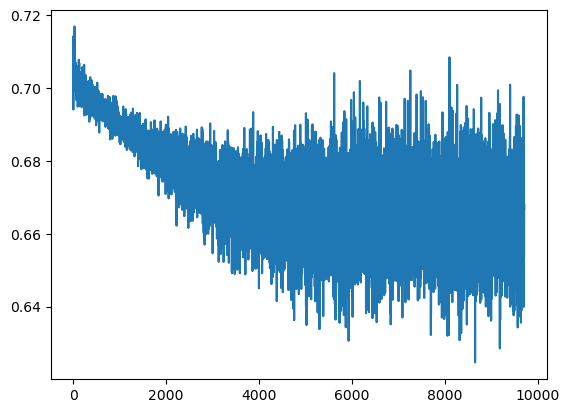

In [137]:
plt.plot(factor_d_losses)

In [104]:
trainer.evaluate(test_loader, False, 0)

(0.2675204804613291, -51.68319818037975)

In [122]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 257.39it/s]


In [123]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

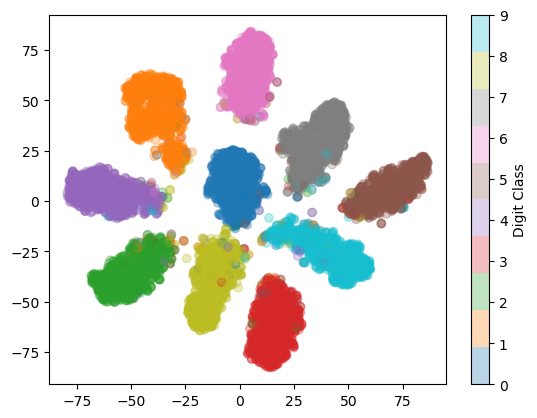

In [124]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

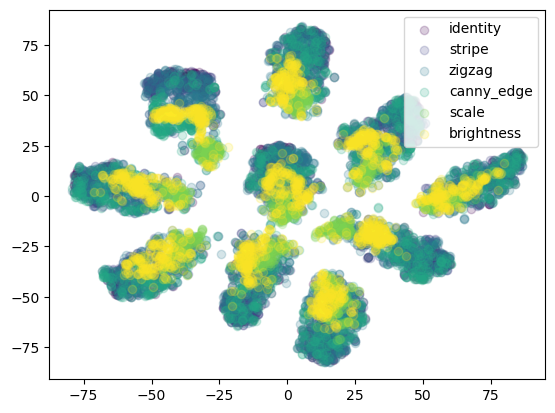

In [125]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [126]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

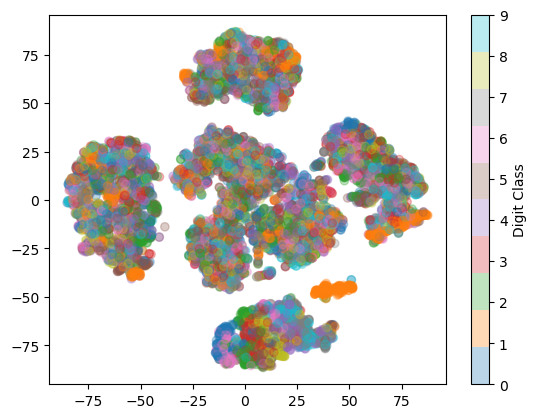

In [127]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

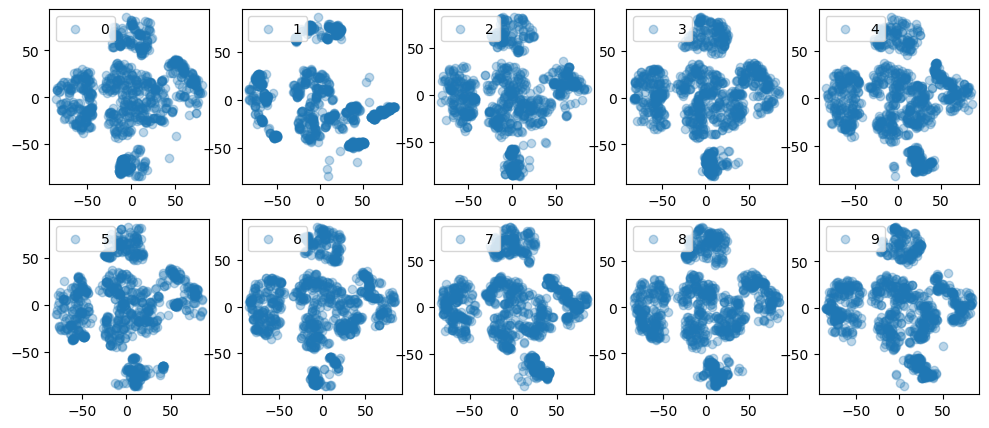

In [128]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3, label=f"{i}")
    ax.legend(loc='upper left')

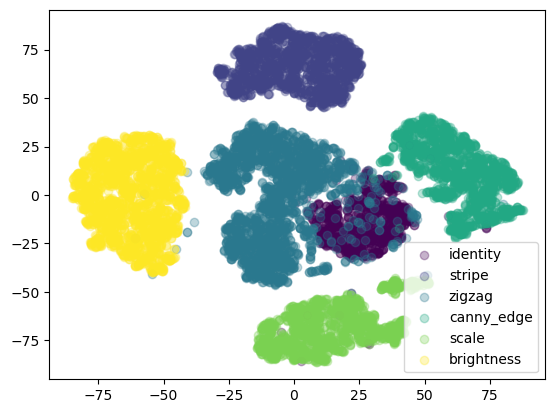

In [129]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [113]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)


interpolate style:


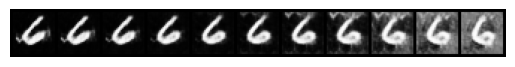

interpolate content:


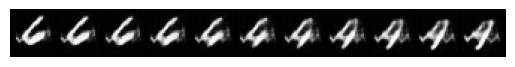

In [114]:
display_util(1, 4, z, vae, int(Z_DIM / 2))

interpolate style:


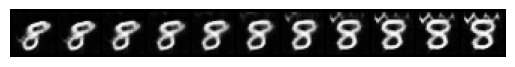

interpolate content:


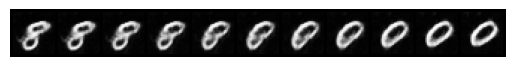

In [115]:
display_util(17, 30, z, vae, int(Z_DIM / 2))

interpolate style:


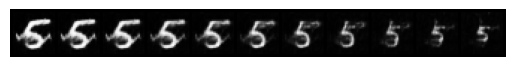

interpolate content:


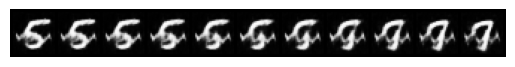

In [116]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


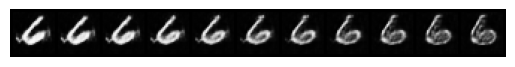

interpolate content:


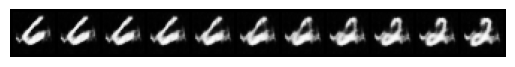

In [117]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [118]:
idx = 1
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))
for i in [136, 120, 84, 50, 52]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))